In [8]:
# improts for our used libs
import utils
import torch
import analyse
import pandas as pd
import numpy as np
import model_simple as ms

from torch import nn
from data_loader import get_loader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

## Create X for model and y for decision tree

In [10]:
# filename = 'PAH3DEEUR_1 Min_Bid_2008.10.21_2018.10.27.csv'
# filename = 'BAYNDEEUR_1 Min_Bid_2015.03.20_2018.10.27.csv'
filename = 'BMWDEEUR_1 Min_Bid_2015.03.24_2018.10.27.csv'

timeframe = 30

In [ ]:
utils.create_X_y(filename, loss_ratio=6, timeframe=30)

In [ ]:
# now we want to create our csv files for X and for y (X = the input for our xgboost and y the output of our xgboost)
# remeber X will be also used for our Autoencoders
X = pd.read_csv('data/X_' + filename)
y = pd.read_csv('data/y_' + filename)

### Just for evaulation

In [ ]:
# check if same length in the table
print(X.shape[0] == y.shape[0])
# show me which values we got :-)
unique, counts = np.unique(y['5'], return_counts=True)
dict(zip(unique, counts))

## create model

In [ ]:
# timeframe is meant the shape of tensor regarding fields
# so can be diffrent from timeframe abofe
ts = 60*24
data = get_loader(data_path='data/X_' + filename, timeframe=ts, batch_size=51280)
# set learning rate and input dim
lr = 1e-1
ds = iter(data)
input_dim = ds.next().shape[2]
# inizialise model
model = ms.SimpleAutoencoder(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# model # to print my model

In [ ]:
# train model
epoch_num = 1
model.cuda()
model.train()
criterion.cuda()
for epoch in range(epoch_num):
    for i, x in enumerate(data):
        # forward
        x = x.float().cuda()
        y = model(x).float().cuda()
        loss = criterion(y, x)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ------- log output ---------
    print('epoch [{}/{}], loss:{:.6f}, MSE_loss:{:.6f}'
          .format(epoch + 1, epoch_num, loss.data, 0))

## evaluate and save model result

In [ ]:
dp = get_loader(data_path='data/X_' + filename, timeframe=ts, batch_size=1)
# prefill results until first dataloader element
result = [0] * ts
criterion.cuda()
for i, x in enumerate(dp):
    # add value to pandas 
    pred = model(x.float().cuda())
    result.append(criterion(x.float().cuda(), pred).data.item())
    if(i % 10000 == 0):
        print('still running ' + str(i))
pd.DataFrame(result).to_csv('data/ym__' + filename, header=None, index=None)

## Decision tree

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [14]:
filename_X = 'data/ym__' + filename
X = pd.read_csv(filename_X, header=None)

# X.describe()

In [20]:
len(np.where(X.values>0.5)[0])

123199

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/lib/histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

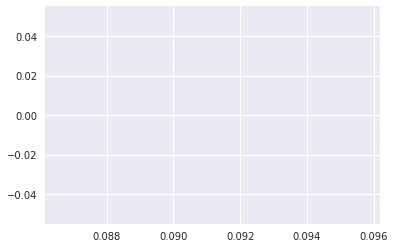

In [16]:
sns.set(color_codes=True)
sns.distplot()

In [7]:
filename_X = "data/ym__" + filename
filename_y = 'data/y_' + filename
# X = pd.read_csv(filename_X, header=None)
# y = pd.read_csv(filename_y)


# utils.xgEvaluation(X, y, y_field='5', i_end=50, debug_i=5, threshold_confusionm=0.3)

ana = analyse.Analyse(filename_X, filename_y, filename)
ana.xgEvaluation(y_field='5', i_end=50, debug_i=5, threshold_confusionm=0.3, showdates=1)

treshhold: 0.3 i: 0
[[395553      0]
 [ 10752      0]]
[]
treshhold: 0.3 i: 5
[[395545      8]
 [ 10749      3]]
['2015.05.29 14:51:00' '2015.06.10 15:14:00' '2015.06.19 09:54:00'
 '2015.07.03 13:01:00' '2015.09.16 15:23:00' '2015.09.24 07:28:00'
 '2015.10.14 10:55:00' '2015.10.16 09:55:00' '2015.12.03 12:39:00'
 '2016.01.07 08:07:00' '2016.01.26 08:07:00']
2015.05.29 14:51:00
2015.06.10 15:14:00
2015.06.19 09:54:00
2015.07.03 13:01:00
2015.09.16 15:23:00
2015.09.24 07:28:00
2015.10.14 10:55:00
2015.10.16 09:55:00
2015.12.03 12:39:00
2016.01.07 08:07:00
2016.01.26 08:07:00
treshhold: 0.3 i: 10
[[395541     12]
 [ 10741     11]]
['2015.04.21 07:13:00' '2015.05.28 13:58:00' '2015.06.11 14:35:00'
 '2015.06.19 10:02:00' '2015.06.22 09:14:00' '2015.06.22 09:15:00'
 '2015.06.22 09:17:00' '2015.07.20 10:43:00' '2015.08.24 07:03:00'
 '2015.09.03 12:39:00' '2015.09.08 07:40:00' '2015.09.21 07:05:00'
 '2015.09.24 07:31:00' '2015.10.26 09:15:00' '2015.10.26 09:17:00'
 '2015.10.28 08:08:00' '2015.

KeyboardInterrupt: 